# Numerical Feature Extraction from Audio

In [4]:
import os
import pandas as pd
import librosa
import numpy as np

# Parameters for feature extraction
sr = 44100  # Sampling rate
frame_len = 2048
hop_length = 512


In [5]:

# Preprocessing function
def preprocess_audio(audio_data, sr):
    # Normalize audio (optional)
    return librosa.util.normalize(audio_data)

# Feature extraction function
def extract_emotion_features(audio_data, sr):
    features = {}
    
    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i}_mean'] = mfcc[i].mean()
        features[f'mfcc_{i}_std'] = mfcc[i].std()
        features[f'mfcc_{i}_min'] = mfcc[i].min()
        features[f'mfcc_{i}_max'] = mfcc[i].max()

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    features['spectral_centroid_mean'] = spectral_centroid.mean()
    features['spectral_centroid_std'] = spectral_centroid.std()

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    features['spectral_bandwidth_mean'] = spectral_bandwidth.mean()
    features['spectral_bandwidth_std'] = spectral_bandwidth.std()

    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    for i in range(spectral_contrast.shape[0]):
        features[f'spectral_contrast_{i}_mean'] = spectral_contrast[i].mean()
        features[f'spectral_contrast_{i}_std'] = spectral_contrast[i].std()

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    for i in range(chroma.shape[0]):
        features[f'chroma_{i}_mean'] = chroma[i].mean()
        features[f'chroma_{i}_std'] = chroma[i].std()

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio_data)
    features['zcr_mean'] = zcr.mean()
    features['zcr_std'] = zcr.std()

    # RMS Energy
    rms = librosa.feature.rms(y=audio_data)
    features['rms_mean'] = rms.mean()
    features['rms_std'] = rms.std()

    return features


In [6]:

# Function to process a folder of audio files
def process_emotion_folder(data_path, folder_name):
    folder_path = os.path.join(data_path, folder_name)
    audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]
    
    all_features = []
    
    for idx, audio_file in enumerate(audio_files, start=1):
        file_path = os.path.join(folder_path, audio_file)
        try:
            # Load audio
            audio_data, _ = librosa.load(file_path, sr=sr)

            # Preprocess and extract features
            preprocessed_audio = preprocess_audio(audio_data, sr)
            features = extract_emotion_features(preprocessed_audio, sr)
            features['label'] = folder_name  # Add the emotion label
            features['file_name'] = audio_file  # Add the file name
            all_features.append(features)

            print(f"Processed {idx}/{len(audio_files)}: {audio_file}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Save features to CSV
    output_csv = f"{folder_name}_features.csv"
    pd.DataFrame(all_features).to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}!")


# CNN-BiLSTM model for numerical feature

In [ ]:

# Load the dataset and necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'SADA_Dataset_Numerical.csv'  # Adjust the file path as needed
dataset = pd.read_csv(file_path)

# Encode the target variable
label_encoder = LabelEncoder()
dataset['emotion_encoded'] = label_encoder.fit_transform(dataset['emotion'])

# Split features and target variable
# Exclude non-numerical columns from features
features = dataset.drop(columns=['label', 'file_name', 'emotion', 'emotion_encoded'])
target = dataset['emotion_encoded']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN input
X_train_scaled = X_train_scaled[..., np.newaxis]  # Add channel dimension
X_test_scaled = X_test_scaled[..., np.newaxis]

# Convert labels to one-hot encoding for multi-class classification
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)


In [ ]:


# Convert DataFrames to NumPy arrays
X_train_array = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()
X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test.to_numpy()

# Reshape data for RNN (RNNs require 3D input: samples, timesteps, features)
X_train_rnn = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])
X_test_rnn = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the model
inputs = Input(shape=(1, X_train_rnn.shape[2]))

# CNN layers
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)  # Add Batch Normalization
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)  # Add Batch Normalization
x = MaxPooling1D(pool_size=2, padding='same')(x)

# BiLSTM layers
x = Bidirectional(LSTM(128, return_sequences=False))(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Increased dropout
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Compile the model
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=8,                  # Stop after 8 epochs of no improvement
    restore_best_weights=True,   # Restore the best weights
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Reduce learning rate when validation loss plateaus
    factor=0.5,                  # Reduce by a factor of 0.5
    patience=4,                  # Wait 4 epochs before reducing
    min_lr=1e-6,                 # Minimum learning rate
    verbose=1
)

# Train the model
history = model.fit(
    X_train_rnn, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_rnn, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.3165 - loss: 1.5153 - val_accuracy: 0.3906 - val_loss: 1.3936 - learning_rate: 1.0000e-04
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3902 - loss: 1.3979 - val_accuracy: 0.3950 - val_loss: 1.3921 - learning_rate: 1.0000e-04
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4042 - loss: 1.3710 - val_accuracy: 0.4214 - val_loss: 1.3390 - learning_rate: 1.0000e-04
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4136 - loss: 1.3564 - val_accuracy: 0.4286 - val_loss: 1.3261 - learning_rate: 1.0000e-04
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4242 - loss: 1.3431 - val_accuracy: 0.4245 - val_loss: 1.3291 - learning_rate: 1.0000e-04
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4291 - loss: 1.3279 - val_accuracy: 0.4325 - val_loss: 1.3162 - learning_rate: 1.0000e-04
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/st

In [ ]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4640 - loss: 1.2532
Test Accuracy: 0.46


In [ ]:
from sklearn.metrics import classification_report

# Predict classes for the test set
y_pred = model.predict(X_test_rnn)
y_pred_classes = y_pred.argmax(axis=1)  # Get the class with the highest probability

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)


438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.53      0.59      0.56      2800
        calm       0.39      0.48      0.43      2800
     disgust       0.48      0.38      0.42      2800
       happy       0.48      0.38      0.42      2800
         sad       0.46      0.49      0.47      2800

    accuracy                           0.46     14000
   macro avg       0.47      0.46      0.46     14000
weighted avg       0.47      0.46      0.46     14000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

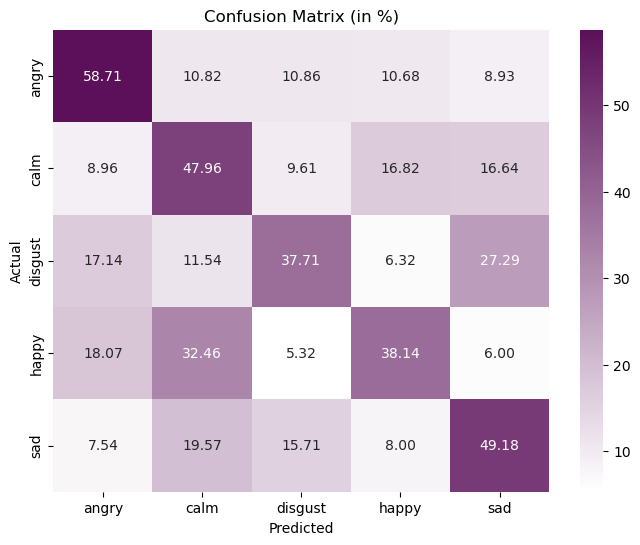

In [ ]:
purple_color = '#5B1059'  # Replace this with the exact hex code if needed
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", ["#ffffff", purple_color])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap=custom_cmap, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (in %)')
plt.show()